## 1. Importing the libraries


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import re
import string
from collections import Counter
from transformers import BertTokenizer, AutoTokenizer, TFAutoModel

import warnings
warnings.filterwarnings('ignore')

In [4]:
df=pd.read_csv('/content/Indian_Domestic_Airline.csv')
df.head()

,AirLine_Name,Rating - 10,Title,Name,Date,Review,Recommond
0,AirAsia India,6.0,"""crew were welcoming""",V Bakshi,14th October 2023,✅ Trip Verified | I had booked this fare at a ...,yes
1,AirAsia India,1.0,"""furious and disappointed""",G Oscar,14th October 2023,✅ Trip Verified | I travel at least four times...,no
2,AirAsia India,10.0,"""amazing service and support""",Rahul Verma,14th October 2023,✅ Trip Verified | Taking this opportunity to a...,yes
3,AirAsia India,1.0,"""Waste of time and money""",G Akron,14th October 2023,✅ Trip Verified | The worst airlines in the hi...,no
4,AirAsia India,8.0,"""thumbs up to boarding crew""",Sirajudeen Jawahar ali,14th October 2023,✅ Trip Verified | Would like to give big thum...,yes


In [5]:
missing_values_count = df.isnull().sum()
missing_values_count

,0
AirLine_Name,0
Rating - 10,4
Title,0
Name,0
Date,0
Review,0
Recommond,0


## 2. Data Preprocessing


In [6]:
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()

percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

0.02585649644473174


In [7]:
df.dropna(subset=['Rating - 10'],inplace=True)

In [8]:
def pos_neg(x):
    if x >= 5:
        return "Postive"
    return "Negative"

df["Rating - 10"] = df["Rating - 10"].apply(pos_neg)

cnt = Counter(df["Rating - 10"])
cnt = dict(cnt)
print(cnt)

{'Postive': 806, 'Negative': 1400}


In [9]:
df['Title'] = df['Title'].str.replace('"', '')

df['Review'] = df['Review'].str.replace("✅ Trip Verified |", "")
df['Review'] = df['Review'].str.replace("not verified |", "")

In [10]:
def wordopt(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df['text'] = df['AirLine_Name'].str.casefold() + ' ' + df['Rating - 10'].str.casefold() + ' ' + df['Title'].str.casefold() + ' ' + df['Review'].str.casefold()
df["text"] = df["text"].apply(wordopt)

In [11]:
df = df.drop(columns=['AirLine_Name','Rating - 10','Title', 'Name', 'Date', 'Review'])
df['Recommond'] = df['Recommond'].map({'yes': 1, 'no': 0})
df.head(10)

,Recommond,text
0,1,airasia india postive crew were welcoming i h...
1,0,airasia india negative furious and disappointe...
2,1,airasia india postive amazing service and supp...
3,0,airasia india negative waste of time and money...
4,1,airasia india postive thumbs up to boarding cr...
5,1,airasia india postive services were good not v...
6,1,airasia india postive thank entire staff of ai...
7,1,airasia india postive impressed with her fluen...
8,0,airasia india negative completely unacceptable...
9,1,airasia india postive hospitality and customer...


## 3. Bert model text encoding

In [12]:
SEQ_LEN = 30
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
train_encoded_inputs = tokenizer(df['text'].tolist(),
                                 add_special_tokens = True,
                                 padding='max_length',
                                 truncation=True,
                                 max_length=SEQ_LEN,
                                 return_token_type_ids=False,
                                 return_tensors = 'tf')

## 4. Tensor Pipelining

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_encoded_inputs, df['Recommond'].values))

In [15]:
def map_bert(inputs, labels):
    inputs = {'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask']}

    return inputs, labels

train_dataset = train_dataset.map(map_bert)

In [16]:
for t in train_dataset.take(2):
    print (t)

({'input_ids': <tf.Tensor: shape=(30,), dtype=int32, numpy=
array([  101,  2250, 15396,  2634,  2695,  3512,  3626,  2020, 18066,
        1045,  2018, 17414,  2023, 13258,  2012,  1037,  2200, 19575,
        2098,  3446,  2004,  1045,  2734,  2000,  3604,  2067,  2000,
        1038, 20974,   102], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(30,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)>}, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
({'input_ids': <tf.Tensor: shape=(30,), dtype=int32, numpy=
array([  101,  2250, 15396,  2634,  4997,  9943,  1998,  9364,  1045,
        3604,  2012,  2560,  2176,  2335,  1037,  3204,  1998,  2250,
        4021,  5621,  8435,  2151,  3462,  2008,  1045,  2031,  2000,
       15175,  2135,   102], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(30,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       

In [17]:
dataset = train_dataset.shuffle(100000).batch(64)
DS_LEN = len(dataset)
DS_LEN

35

## 5. Training and Validation splitting


In [18]:
SPLIT = 0.8
train_ds = dataset.take(round(DS_LEN*SPLIT))
val_ds = dataset.skip(round(DS_LEN*SPLIT))

print(train_ds)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(None, 30), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 30), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


## Modeling


In [19]:
bert = TFAutoModel.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [20]:
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), dtype=np.int32, name='input_ids' )
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), dtype=np.int32,  name = 'attention_mask')

embeddings = bert([input_ids, mask])[0]
cls_token = embeddings[:,0,:]

x = tf.keras.layers.BatchNormalization()(cls_token)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)

y = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 30)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 30)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 30, 76                                       

In [22]:
model.layers[2].trainable = False
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 30)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 30)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 30, 76                                       

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy('accuracy')])

callbacks = [tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.1,min_delta=0.001,monitor='val_loss'),
             tf.keras.callbacks.EarlyStopping(patience=5, min_delta=0.001, monitor='val_loss')]

history = model.fit(train_ds, validation_data = val_ds, epochs = 50, callbacks = callbacks)

Epoch 1/50
28/28 [==============================] - 30s 384ms/step - loss: 0.5231 - accuracy: 0.7327 - val_loss: 0.4690 - val_accuracy: 0.7367 - lr: 5.0000e-04
Epoch 2/50
28/28 [==============================] - 5s 160ms/step - loss: 0.3121 - accuracy: 0.8800 - val_loss: 0.3510 - val_accuracy: 0.8816 - lr: 5.0000e-04
Epoch 3/50
28/28 [==============================] - 5s 177ms/step - loss: 0.2585 - accuracy: 0.9018 - val_loss: 0.3633 - val_accuracy: 0.8744 - lr: 5.0000e-04
Epoch 4/50
28/28 [==============================] - 5s 164ms/step - loss: 0.2527 - accuracy: 0.8929 - val_loss: 0.3014 - val_accuracy: 0.8986 - lr: 5.0000e-04
Epoch 5/50
28/28 [==============================] - 5s 162ms/step - loss: 0.2442 - accuracy: 0.9074 - val_loss: 0.2632 - val_accuracy: 0.9155 - lr: 5.0000e-04
Epoch 6/50
28/28 [==============================] - 5s 180ms/step - loss: 0.2187 - accuracy: 0.9146 - val_loss: 0.2616 - val_accuracy: 0.9324 - lr: 5.0000e-04
Epoch 7/50
28/28 [===========================

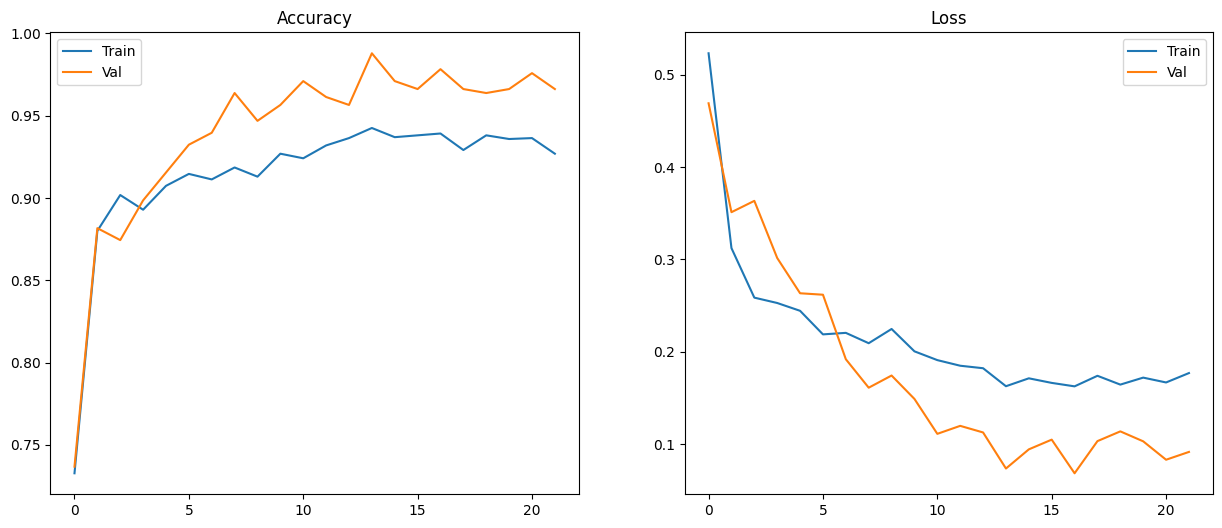

In [24]:
epochs = history.epoch
plt.figure(figsize=(15, 6))

plt.subplot(1,2, 1)
plt.plot(epochs, history.history['accuracy'], label="Train")
plt.plot(epochs, history.history['val_accuracy'], label = "Val")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2, 2)
plt.plot(epochs, history.history['loss'], label="Train")
plt.plot(epochs, history.history['val_loss'], label = "Val")
plt.legend()
plt.title("Loss")

plt.show()